# LAB 2 - Precipitation Nowcasting

1. Feedforward Neural Network
2. Convolutional Neural Networks (CNN)
3. Recurrent Neural Networks (RNN)


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
# from ipywidgets import fixed, widgets, interact, interact_manual

rng = np.random.RandomState(1)

In [3]:
# Clone the entire repo.
!git clone https://github.com/sunnypwang/mwa_workshop.git

Cloning into 'mwa_workshop'...
Updating files:  38% (10/26)
Updating files:  42% (11/26)
Updating files:  46% (12/26)
Updating files:  50% (13/26)
Updating files:  53% (14/26)
Updating files:  57% (15/26)
Updating files:  61% (16/26)
Updating files:  65% (17/26)
Updating files:  69% (18/26)
Updating files:  73% (19/26)
Updating files:  76% (20/26)
Updating files:  80% (21/26)
Updating files:  84% (22/26)
Updating files:  88% (23/26)
Updating files:  92% (24/26)
Updating files:  96% (25/26)
Updating files: 100% (26/26)
Updating files: 100% (26/26), done.


## Precipitation Nowcasting ##

Precipitation nowcasting is the the task of predicting the amount of rainfall in a certain region given some kind of sensor data.  The term nowcasting refers to tasks that try to predict the current or near future conditions (within 6 hours). 

You will be given satellite images in 3 different bands covering a 5 by 5 region from different parts of Thailand. In other words, your input will be a 5x5x3 image. Your task is to predict the amount of rainfal in the center pixel. You will first do the prediction using just a simple fully-connected neural network that view each pixel as different input features.

Since the your input is basically an image, we will then view the input as an image and apply CNN to do the prediction. Finally, we can also add a time component since weather prediction can benefit greatly using previous time frames. Each data point actually contain 5 time steps, so each input data point has a size of 5x5x5x3 (time x height x width x channel), and the output data has a size of 5 (time). You will use this time information when you work with RNNs.

Finally, we would like to thank the Thai Meteorological Department for providing the data for this assignment.

### Data Explanation

The data is an hourly measurement of water vapor in the atmosphere, and two infrared measurements of cloud imagery on a latitude-longitude coordinate. Each measurement is illustrated below as an image. These three features are included as different channels in your input data.

<img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/wvapor.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud1.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud2.png" width="200">

We also provide the hourly precipitation (rainfall) records in the month of June, July, August, September, and October from weather stations spreaded around the country. A 5x5 grid around each weather station at a particular time will be paired with the precipitation recorded at the corresponding station as input and output data. Finally, five adjacent timesteps are stacked into one sequence.

The month of June-August are provided as training data, while the months of September and October are used as validation and test sets, respectively.

**features** 
- dim 0: number of entries
- dim 1: number of time-steps in ascending order
- dim 2,3: a 5x5 grid around rain-measued station
- dim 4: water vapor and two cloud imagenaries 

**labels**
- dim 0: number of entries
- dim 1: number of precipitation for each time-step


### Load Data

In [12]:
from sklearn.model_selection import train_test_split
def read_data(months, data_dir='mwa_workshop/lab1'):
    features = np.array([], dtype=np.float32).reshape(0,5,5,5,3)
    labels = np.array([], dtype=np.float32).reshape(0,5)
    for m in months:
        for i in range(2):
            filename = 'features-m{}_{}.pk'.format(m,i)
            with open(os.path.join(data_dir,filename), 'rb') as file:
                features_temp = pickle.load(file)
            features = np.concatenate((features, features_temp), axis=0)
            
        filename = 'labels-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            labels_temp = pickle.load(file)
        labels = np.concatenate((labels, labels_temp), axis=0)
    
    return features, labels

In [13]:
# use data from month 6,7,8 as training set
x_train, y_train = read_data(months=[6,7,8])

# use data from month 9 as validation set
x_val, y_val = read_data(months=[9])

# use data from month 10 as test set
x_test, y_test = read_data(months=[10])

print('x_train shape:',x_train.shape)
print('y_train shape:', y_train.shape, '\n')
print('x_val shape:',x_val.shape)
print('y_val shape:', y_val.shape, '\n')
print('x_test shape:',x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (229548, 5, 5, 5, 3)
y_train shape: (229548, 5) 

x_val shape: (92839, 5, 5, 5, 3)
y_val shape: (92839, 5) 

x_test shape: (111715, 5, 5, 5, 3)
y_test shape: (111715, 5)


### Explore Data

Label (Rainfall)

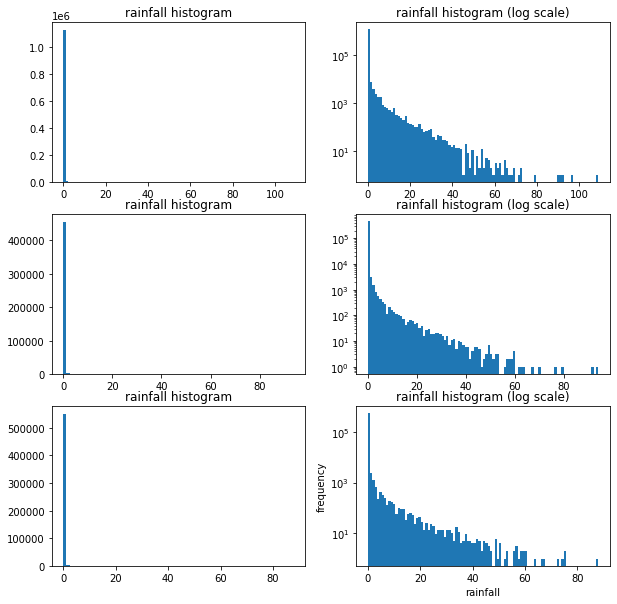

In [14]:
plt.figure(figsize=(10,10))

plt.subplot(3,2,1)
plt.hist(y_train.flatten(),bins=100)
plt.title('rainfall histogram')
plt.subplot(3,2,2)
plt.hist(y_train.flatten(),bins=100,log=True)
plt.title('rainfall histogram (log scale)')

plt.subplot(3,2,3)
plt.hist(y_val.flatten(),bins=100)
plt.title('rainfall histogram')
plt.subplot(3,2,4)
plt.hist(y_val.flatten(),bins=100,log=True)
plt.title('rainfall histogram (log scale)')

plt.subplot(3,2,5)
plt.hist(y_test.flatten(),bins=100)
plt.title('rainfall histogram')
plt.subplot(3,2,6)
plt.hist(y_test.flatten(),bins=100,log=True)
plt.title('rainfall histogram (log scale)')

plt.xlabel('rainfall')
plt.ylabel('frequency')
plt.show()

Features (Vapor, Infrared-1, Infrared-2)

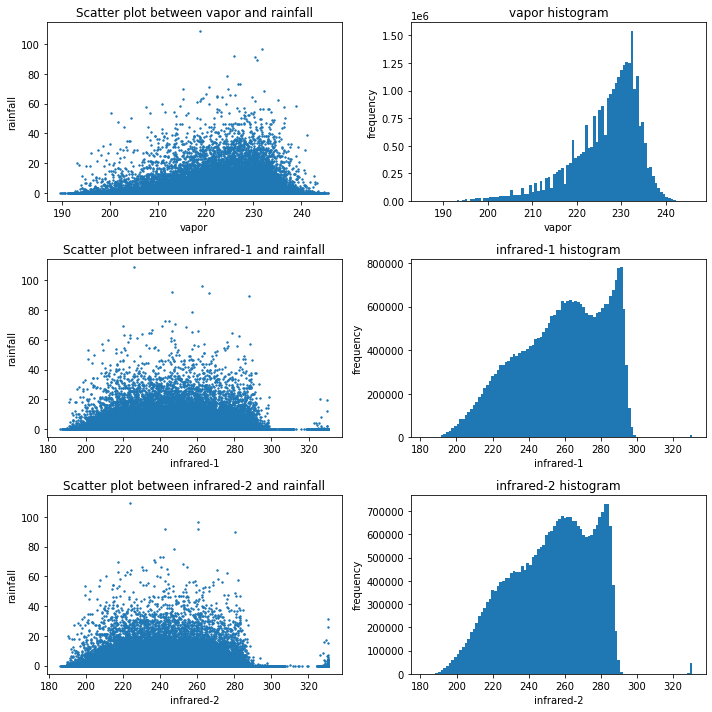

In [15]:
features = ['vapor','infrared-1','infrared-2']
plt.figure(figsize=(10,10))
for i in range(3):
    plt.subplot(3,2,i*2+1)
    plt.scatter(x_train.mean(axis=(2,3)).reshape(-1,3)[:,i], y_train.flatten(), s=2)
    plt.title('Scatter plot between {} and rainfall'.format(features[i]))
    plt.xlabel(features[i])
    plt.ylabel('rainfall')
    plt.subplot(3,2,i*2+2)
    plt.hist(x_train[:,:,:,:,i].flatten(),bins=100)
    plt.title(features[i] + ' histogram')
    plt.xlabel(features[i])
    plt.ylabel('frequency')
plt.tight_layout()
plt.show()

### Normalize Data

We will normalize the data $X_i$ by subtracting the mean $\mu_i$ and divide by standard deviation $\sigma_i$ seperately for each feature $i$

$$Z_i = \frac{X_i - \mu_i}{\sigma_i}$$

In [16]:
# mean_train = np.mean(x_train)
# std_train = np.std(x_train)
mean_train = x_train.reshape(-1, 3).mean(axis=0,dtype=np.float64)
std_train = x_train.reshape(-1, 3).std(axis=0,dtype=np.float64)
print(mean_train)
print(std_train)

[226.53945784 258.0860329  252.47822637]
[ 7.62826918 24.29778124 23.08137511]


In [17]:
x_train = (x_train - mean_train) / std_train
x_val = (x_val - mean_train) / std_train
x_test = (x_test - mean_train) / std_train

## About the libraries

**Tensorflow**

TensorFlow is a free and open-source software library for dataflow and differentiable programming across a range of tasks. It is a symbolic math library, and is also used for machine learning applications such as neural networks.

TensorFlow offers multiple levels of abstraction so you can choose the right one for your needs. Build and train models by using the high-level Keras API, which makes getting started with TensorFlow and machine learning easy.

![Tensorflow](https://upload.wikimedia.org/wikipedia/commons/thumb/1/11/TensorFlowLogo.svg/330px-TensorFlowLogo.svg.png)

**Keras**

Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.

Use Keras if you need a deep learning library that:

- Allows for easy and fast prototyping (through user friendliness, modularity, and extensibility).
- Supports both convolutional networks and recurrent networks, as well as combinations of the two.
- Runs seamlessly on CPU and GPU.

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

## Feedforward Neural Networks

Let's start with using a simple three-layer feedforward neural network. The features we will use are points in 5*5 grids and 3 channels (total of 75 features). The output is the amount of rainfall in millimeters (1 label)

The image below illustrates a brief concept of how neural networks work. Note that our model has a different architecture in term of number of nodes in each layer.

![](https://cs.stanford.edu/people/eroberts/courses/soco/projects/neural-networks/Architecture/images/feedforward.jpg)

In [19]:
# Python function wrapper for training model
def train_model(model,x_train,y_train,x_val,y_val,callbacks=None,epochs=5,batch_size=32,verbose=1):
    print('start training...')
    hists = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                    callbacks=callbacks, validation_data=(x_val, y_val))
    return hists

In [20]:
# Dataset need to be reshaped to make it suitable for feedforword model
def preprocess_for_ff(x, y):
    x = x.reshape((-1, 5*5*3))
    y = y.reshape((-1, 1))
    return x, y

x_train_ff, y_train_ff = preprocess_for_ff(x_train, y_train)
x_val_ff, y_val_ff = preprocess_for_ff(x_val, y_val)
x_test_ff, y_test_ff = preprocess_for_ff(x_test, y_test)

print("x train size:",x_train_ff.shape)
print("y train size:",y_train_ff.shape)

print("x val size:",x_val_ff.shape)
print("y val size:",y_val_ff.shape)

print("x test size:",x_test_ff.shape)
print("y test size:",y_test_ff.shape)

x train size: (1147740, 75)
y train size: (1147740, 1)
x val size: (464195, 75)
y val size: (464195, 1)
x test size: (558575, 75)
y test size: (558575, 1)


In [21]:
def get_feedforward_nn():
    input1 = Input(shape=(75,))    
    x = Dense(200, activation='relu')(input1)    
    x = Dense(200, activation='relu')(x)
    x = Dense(200, activation='relu')(x)
    out = Dense(1)(x)

    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(),
                loss='mse',
                metrics=['mse'])

    return model

K.clear_session() 
model = get_feedforward_nn()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75)]              0         
_________________________________________________________________
dense (Dense)                (None, 200)               15200     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 95,801
Trainable params: 95,801
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Path to save model parameters
weight_path_model_ff ='model_ff_nn.h5'
callbacks=[
           ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001),
           ModelCheckpoint(
            weight_path_model_ff,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
]

epochs = 10
batch_size = 1024
reg_hists = train_model(model,
            x_train_ff,y_train_ff,
            x_val_ff,y_val_ff,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            )
model.load_weights(weight_path_model_ff)

start training...
Train on 1147740 samples, validate on 464195 samples
Epoch 1/10
1140736/1147740 [============================>.] - ETA: 0s - loss: 1.9228 - mse: 1.9228
Epoch 00001: val_loss improved from inf to 1.65914, saving model to model_ff_nn.h5
1147740/1147740 [==============================] - 6s 6us/sample - loss: 1.9214 - mse: 1.9214 - val_loss: 1.6591 - val_mse: 1.6591
Epoch 2/10
1146880/1147740 [============================>.] - ETA: 0s - loss: 1.9200 - mse: 1.9200
Epoch 00002: val_loss did not improve from 1.65914
1147740/1147740 [==============================] - 6s 5us/sample - loss: 1.9189 - mse: 1.9189 - val_loss: 1.6602 - val_mse: 1.6602
Epoch 3/10
1139712/1147740 [============================>.] - ETA: 0s - loss: 1.9198 - mse: 1.9198
Epoch 00003: val_loss did not improve from 1.65914
1147740/1147740 [==============================] - 6s 5us/sample - loss: 1.9185 - mse: 1.9185 - val_loss: 1.6593 - val_mse: 1.6593
Epoch 4/10
1141760/1147740 [==========================

In [23]:
def plot_loss(hists,train_data=True,start=0):
    if not train_data:
        plt.plot(hists.history['val_loss'][start:])
        plt.title('val loss')
    else:
        plt.plot(hists.history['loss'][start:])
        plt.title('train loss')
        plt.legend(['train'])
    ticks = np.arange(len(hists.history['loss'][start:])) + start
    plt.xticks(ticks,ticks+1)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid(True)
    plt.show()

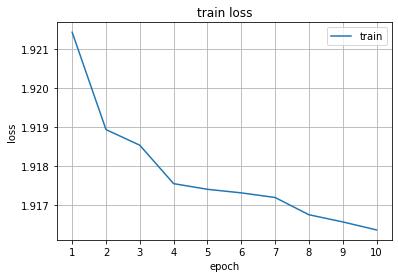

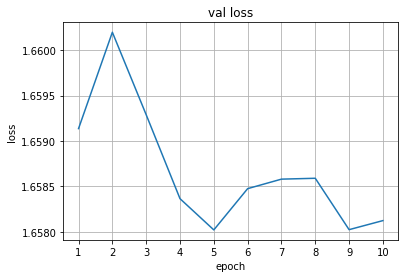

In [24]:
plot_loss(reg_hists,True)
plot_loss(reg_hists,False)

In [25]:
def evaluate(model, x, y):
    loss,mse = model.evaluate(x,y, verbose=0)
    print('MSE : {:.4f}'.format(mse))

In [26]:
evaluate(model, x_test_ff, y_test_ff)

MSE : 1.1616


# Dropout

Dropout can help reduce the overfittting.
Let's add a dropout layer. The recommended value for dropout rate is between 0.2 - 0.5.

In [27]:
def get_feedforward_nn():
    input1 = Input(shape=(75,))    
    x = Dense(200, activation='relu')(input1)
    x = Dropout(0.2)(x)    
    x = Dense(200, activation='relu')(x)
    x = Dropout(0.2)(x) 
    x = Dense(200, activation='relu')(x)
    x = Dropout(0.2)(x) 
    out = Dense(1)(x)

    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(),
                loss='mse',
                metrics=['mse'])

    return model
  
K.clear_session() 
model = get_feedforward_nn()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75)]              0         
_________________________________________________________________
dense (Dense)                (None, 200)               15200     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0     

In [28]:
# Path to save model parameters
weight_path_model_ff_drop ='model_ff_nn_drop.h5'
callbacks=[
           ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001),
           ModelCheckpoint(
            weight_path_model_ff_drop,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
]

epochs = 15
batch_size = 1024
reg_hists = train_model(model,
            x_train_ff,y_train_ff,
            x_val_ff,y_val_ff,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            )
model.load_weights(weight_path_model_ff_drop)

start training...
Train on 1147740 samples, validate on 464195 samples
Epoch 1/15
1141760/1147740 [============================>.] - ETA: 0s - loss: 1.9252 - mse: 1.9252
Epoch 00001: val_loss improved from inf to 1.65901, saving model to model_ff_nn_drop.h5
1147740/1147740 [==============================] - 12s 11us/sample - loss: 1.9234 - mse: 1.9234 - val_loss: 1.6590 - val_mse: 1.6590
Epoch 2/15
1144832/1147740 [============================>.] - ETA: 0s - loss: 1.9211 - mse: 1.9211
Epoch 00002: val_loss did not improve from 1.65901
1147740/1147740 [==============================] - 11s 10us/sample - loss: 1.9195 - mse: 1.9195 - val_loss: 1.6592 - val_mse: 1.6592
Epoch 3/15
1142784/1147740 [============================>.] - ETA: 0s - loss: 1.9167 - mse: 1.9167
Epoch 00003: val_loss did not improve from 1.65901
1147740/1147740 [==============================] - 11s 10us/sample - loss: 1.9190 - mse: 1.9190 - val_loss: 1.6594 - val_mse: 1.6594
Epoch 4/15
1141760/1147740 [===============

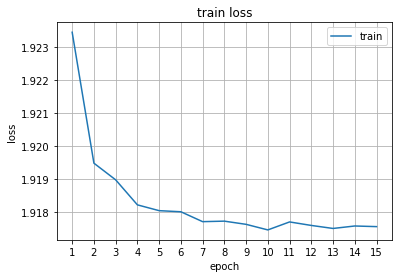

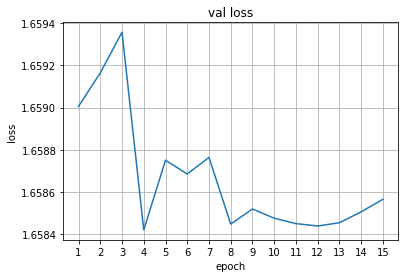

MSE : 1.1630


In [29]:
plot_loss(reg_hists,True)
plot_loss(reg_hists,False)
evaluate(model, x_test_ff, y_test_ff)

The difference between training and validation is smaller (less overfitting). However, the training loss is also higher (higher bias).

# Convolution Neural Network

Let's try applying CNN to the task. We'll treat each slice individually.

In [30]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten

In [31]:
def preprocess_for_cnn(x, y):
    x_ff, y_ff = preprocess_for_ff(x, y)
    
    x_cnn = x_ff.reshape((-1,5,5,3))
    y_cnn = y_ff.reshape(-1,1)
    
    return x_cnn, y_cnn

x_train_cnn, y_train_cnn = preprocess_for_cnn(x_train, y_train)
x_val_cnn, y_val_cnn = preprocess_for_cnn(x_val, y_val)
x_test_cnn, y_test_cnn = preprocess_for_cnn(x_test, y_test)
print("x size:",x_train_cnn.shape)
print("y size:",y_train_cnn.shape)

x size: (1147740, 5, 5, 3)
y size: (1147740, 1)


In [32]:
def get_conv2d_nn():
    input1 = Input(shape=(5,5,3))
    x = Conv2D(200, (3,3), strides=(1,1), padding='valid', activation='relu')(input1)
    x = Flatten()(x)
    x = Dense(200, activation='relu')(x)
    x = Dense(200, activation='relu')(x)
    out = Dense(1, activation='relu')(x)

    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(),
                loss='mse',
                metrics=['mse'])
    return model
K.clear_session() 
model = get_conv2d_nn()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 5, 3)]         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 3, 3, 200)         5600      
_________________________________________________________________
flatten (Flatten)            (None, 1800)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               360200    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 406,201
Trainable params: 406,201
Non-trainable params: 0
_______________________________________________________

In [33]:
# Path to save model parameters
weight_path_model_cnn ='model_ff_cnn.h5'
callbacks=[
           ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001),
           ModelCheckpoint(
            weight_path_model_cnn,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
]

epochs = 15
batch_size = 1024
reg_hists = train_model(model,
            x_train_cnn,y_train_cnn,
            x_val_cnn,y_val_cnn,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            )
model.load_weights(weight_path_model_cnn)

start training...
Train on 1147740 samples, validate on 464195 samples
Epoch 1/15
1144832/1147740 [============================>.] - ETA: 0s - loss: 1.9191 - mse: 1.9191
Epoch 00001: val_loss improved from inf to 1.66021, saving model to model_ff_cnn.h5
1147740/1147740 [==============================] - 22s 19us/sample - loss: 1.9207 - mse: 1.9207 - val_loss: 1.6602 - val_mse: 1.6602
Epoch 2/15
1144832/1147740 [============================>.] - ETA: 0s - loss: 1.9172 - mse: 1.9172
Epoch 00002: val_loss improved from 1.66021 to 1.66007, saving model to model_ff_cnn.h5
1147740/1147740 [==============================] - 22s 19us/sample - loss: 1.9191 - mse: 1.9191 - val_loss: 1.6601 - val_mse: 1.6601
Epoch 3/15
1145856/1147740 [============================>.] - ETA: 0s - loss: 1.9175 - mse: 1.9175
Epoch 00003: val_loss improved from 1.66007 to 1.65866, saving model to model_ff_cnn.h5
1147740/1147740 [==============================] - 22s 19us/sample - loss: 1.9187 - mse: 1.9187 - val_loss

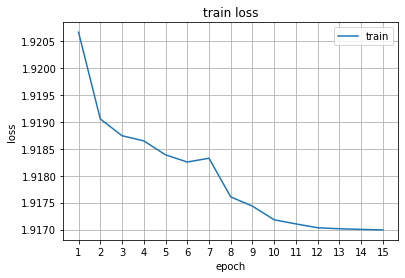

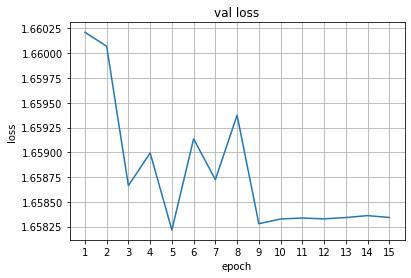

MSE : 1.1609


In [34]:
plot_loss(reg_hists,True)
plot_loss(reg_hists,False)
evaluate(model, x_test_cnn, y_test_cnn)

# Recurrent network

We will try using time information instead of the grid information.

TimeDistributed wrapper will use the same dense weights over multiple time steps.

In [35]:
from tensorflow.keras.layers import GRU,TimeDistributed

In [36]:
def preprocess_for_gru(x, y):
    x_ff, y_ff = preprocess_for_ff(x, y)

    x_gru = x_ff.reshape(len(x),5,-1)
    y_gru = y_ff.reshape(len(y),5)
   
    return x_gru, y_gru

x_train_gru, y_train_gru = preprocess_for_gru(x_train, y_train)
x_val_gru, y_val_gru = preprocess_for_gru(x_val, y_val)
x_test_gru, y_test_gru = preprocess_for_gru(x_test, y_test)
print("x size:",x_train_gru.shape)
print("y size:",y_train_gru.shape)

x size: (229548, 5, 75)
y size: (229548, 5)


In [37]:
def get_gru():
    input1 = Input(shape=(5,75))
    x = GRU(100, return_sequences=True)(input1)
    x = TimeDistributed(Dense(200, activation='relu'))(x)
    x = TimeDistributed(Dense(1, activation='relu'))(x)
    out = Flatten()(x)

    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(),
                loss='mse',
                metrics=['mse'])   
    return model
K.clear_session() 
model = get_gru()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 75)]           0         
_________________________________________________________________
gru (GRU)                    (None, 5, 100)            53100     
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 200)            20200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 1)              201       
_________________________________________________________________
flatten (Flatten)            (None, 5)                 0         
Total params: 73,501
Trainable params: 73,501
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Path to save model parameters
weight_path_model_gru ='model_ff_gru.h5'
callbacks=[
           ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001),
           ModelCheckpoint(
            weight_path_model_gru,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
]

epochs = 15
batch_size = 1024
reg_hists = train_model(model,
            x_train_gru,y_train_gru,
            x_val_gru,y_val_gru,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            )
model.load_weights(weight_path_model_gru)

start training...
Train on 229548 samples, validate on 92839 samples
Epoch 1/15
228352/229548 [============================>.] - ETA: 0s - loss: 1.9232 - mse: 1.9232
Epoch 00001: val_loss improved from inf to 1.65797, saving model to model_ff_gru.h5
229548/229548 [==============================] - 11s 47us/sample - loss: 1.9202 - mse: 1.9202 - val_loss: 1.6580 - val_mse: 1.6580
Epoch 2/15
228352/229548 [============================>.] - ETA: 0s - loss: 1.9147 - mse: 1.9147
Epoch 00002: val_loss improved from 1.65797 to 1.65707, saving model to model_ff_gru.h5
229548/229548 [==============================] - 9s 40us/sample - loss: 1.9156 - mse: 1.9156 - val_loss: 1.6571 - val_mse: 1.6571
Epoch 3/15
228352/229548 [============================>.] - ETA: 0s - loss: 1.9139 - mse: 1.9139
Epoch 00003: val_loss did not improve from 1.65707
229548/229548 [==============================] - 9s 39us/sample - loss: 1.9145 - mse: 1.9145 - val_loss: 1.6573 - val_mse: 1.6573
Epoch 4/15
228352/229548 [

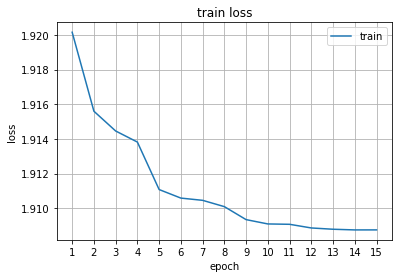

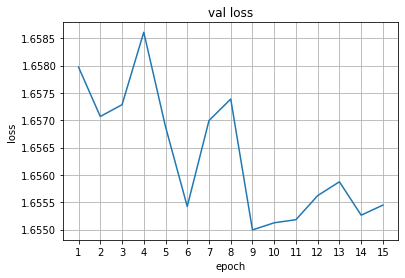

MSE : 1.1615


In [39]:
plot_loss(reg_hists,True)
plot_loss(reg_hists,False)
evaluate(model, x_test_gru, y_test_gru)

In this final part, you should try to create your own model for this task.

Ideas to try:
  - Add dropout to the GRU or CNN model
  - Combine GRU and CNN model. Use CNN on the grid to capture local structure then pass the output to the GRU to capture temporal information
  - Optimize the hyperparameters

In [40]:
# Create data

In [41]:
# Define model

In [42]:
# Train model

In [43]:
# Evaluate model